<img src="https://github.com/AILab-MLTools/LightAutoML/raw/master/imgs/LightAutoML_logo_big.png" alt="LightAutoML logo" style="width:70%;"/>

# LightAutoML baseline

Official LightAutoML github repository is [here](https://github.com/AILab-MLTools/LightAutoML). 

### Do not forget to put upvote for the notebook, follow me on Kaggle and the ⭐️ for github repo if you like it - one click for you, great pleasure for us ☺️ 
### If you miss the [simple baseline notebook](https://www.kaggle.com/code/alexryzhkov/clone-my-notebook) for this competition, please take a look and upvote it as well. 

## This notebook is the updated copy of our [Tutorial_1 from the GIT repository](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials/Tutorial_1_basics.ipynb). Please check our [tutorials folder](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials) if you are interested in other examples of LightAutoML functionality.

## 0. Prerequisites

### 0.0. install LightAutoML

In [1]:
# %%capture
# !pip install lightautoml

# # QUICK WORKAROUND FOR PROBLEM WITH PANDAS
# !pip install -U pandas

### 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: `TabularAutoML` preset for AutoML model creation and Task class to setup what kind of ML problem we solve (binary/multiclass classification or regression)

In [2]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
pd.set_option('display.float_format', '{:.2f}'.format)

### 0.2. Constants

Here we setup the constants to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [4]:
N_THREADS = 12
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 30 * 60 # equal to 15 minutes
TARGET_NAME = 'final_price'

### 0.3. Imported models setup

For better reproducibility fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [5]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### 0.4. Data loading
Let's check the data we have:

In [6]:
INPUT_DIR = './input/sf-dst-predict-car-price/'

In [7]:
train_data = pd.read_csv(INPUT_DIR + 'train_data.csv')
print(train_data.shape)
train_data.head()

(35000, 15)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.00
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.00
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.00
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.00
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.00


In [8]:
test_data = pd.read_csv(INPUT_DIR + 'test_data.csv')
print(test_data.shape)
test_data.head()

(10697, 14)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type
0,35000,TOYOTA,Prius,Hatchback,323733,2012,Automatic,4/5,Left wheel,Grey,Black,JTDKN3DU6C5439638,1,For Sale
1,35001,HYUNDAI,Elantra,Sedan,112000,2013,Tiptronic,4/5,Left wheel,Grey,Black,SURATSHIA,1,For Sale
2,35002,LEXUS,NX 300,Jeep,16920,2018,Automatic,NaN,Left wheel,Brown,NaN,JTJYARBZ5J2104521,1,For Sale
3,35003,LEXUS,CT 200h,Hatchback,302742,2012,Automatic,4/5,Left wheel,White,NaN,JTHKD5BH4C2070945,1,For Sale
4,35004,TOYOTA,RAV 4,Jeep,1800,2002,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale


In [9]:
submission = pd.read_csv(INPUT_DIR + 'sample_submission.csv')
print(submission.shape)
submission.head()

(10697, 2)


,row_ID,final_price
0,35000,0
1,35001,0
2,35002,0
3,35003,0
4,35004,0


### Step 0.5. Some user feature preparation

Be creative :)

Для начала удалим все ведущие и замыкающие пробелы, а также приведем все к нижнему регистру в тектовых данных

In [10]:
def clear_string_value(value: str) -> str:
    """
    Remove heading and trailing spaces from value or return None if value is not str

    Args:
        value (str): input string with headinng and trailing spaces

    Returns:
        str: clear output sting or None
    """
    
    return value.strip().lower() if isinstance(value, str) else None

In [11]:
object_cols = train_data.select_dtypes('object').columns
train_data.loc[:, object_cols] = train_data.loc[:, object_cols].applymap(clear_string_value)
test_data.loc[:, object_cols] = test_data.loc[:, object_cols].applymap(clear_string_value)

In [12]:
def get_top_unique_values(df, level=0):
    """
    Функция для получения инфомации по уникальным значениям в признаках

    :param df: Датафрейм для анализа
    :param level: Уровень уникальности в %, признаки ниже этого уровня не выводятся
    :return: Возвращает датафрейм с именем признака, количестве уникальных значений, наиболее часто повторяющимся
    уникальным значением, сколько % от выборки это значение занимает, количество повторов
    """

    cols = list(df.columns)

    # создаём пустой список
    unique_list = []

    for col in cols:
        col_lev = round(df[col].value_counts(normalize=True).values[0] * 100, 2)

        if col_lev > level:
            item = (col, df[col].nunique(), df[col].value_counts(normalize=True).index[0], col_lev,
                    df[col].value_counts().values[0])
            # добавляем кортеж в список
            unique_list.append(item)

    unique_values = pd.DataFrame(
        unique_list,
        columns=['Column Name', 'Count Unique', 'Top Value', 'Top Value %', 'Top Value Count']
    )

    return unique_values

In [13]:
def outliers_iqr(df, feature, log_scale=False, left=1.5, right=1.5):
    """
    Функция для определения выбросов по методу Тьюки.

    :param df: Исходный датафрейм
    :param feature: Фитча датафрейма для определения выбросов
    :param log_scale: Нужно ли логарифмировать рассмативаемый признак
    :param left: Множитель для определения левой границы выброса, по умолчанию 1.5
    :param right: Множитель для определения правой границы выброса, по умолчанию 1.5
    :return: Функция возвращает датафрейм с выбросами и отчищенный от выбросов датафрейм
    """

    x = df[feature]

    if log_scale:
        x = np.log(x)

    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1

    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)

    outliers = df[(x < lower_bound) | (x > upper_bound)]
    cleaned = df[(x > lower_bound) & (x < upper_bound)]
    info = f'Выбросы: {outliers.shape[0]} строк ({outliers.shape[0] / df.shape[0] * 100:.2f}%).'

    return info, outliers, cleaned

In [14]:
def Hist_and_Box_Plots(df, column_name, bins=30):
    """
    Функция для построения диаграммы распределения и коробки с усами
    для оценки нормальности распределения и поиска выбросов

    :param df: Исходный датафрейм
    :param column_name: Имя признака для анализа
    :param bins: Количество групп по умолчанию 30
    :return: Выводит график
    """

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
    axes[0].ticklabel_format(style='plain', axis='x')
    histplot = sns.histplot(data=df, x=column_name, bins=bins, ax=axes[0])

    histplot.set_title(f'{column_name} Histogram')
    axes[1].ticklabel_format(style='plain', axis='x')
    boxplot = sns.boxplot(data=df, x=column_name, ax=axes[1])
    boxplot.set_title(f'{column_name} Boxplot')

    plt.tight_layout()
    plt.show()

In [15]:
get_top_unique_values(train_data)

,Column Name,Count Unique,Top Value,Top Value %,Top Value Count
0,vehicle_manufacturer,68,toyota,19.34,6768
1,vehicle_model,2067,prius,6.72,2350
2,vehicle_category,11,sedan,44.24,15483
3,current_mileage,11273,0,4.01,1403
4,vehicle_year,68,2012,11.20,3919
5,vehicle_gearbox_type,4,automatic,69.40,24290
6,doors_cnt,3,4/5,94.72,32446
7,wheels,2,left wheel,92.02,32207
8,vehicle_color,16,black,26.17,9053
9,vehicle_interior_color,11,black,74.55,21083


### Признак deal_type

In [16]:
# Посмотрю на медианные цену и пробег в разрезе типа сделки
# Вижу сильный перекос в медианной цене. Это вообще два разных по логике события, покупка и аренда машины.
# Кроме того, количетсво записей по аренде это совсем незначительная доля от общей выборки 
train_data.groupby('deal_type').agg({'deal_type': 'count', 'final_price': 'median', 'current_mileage': 'median'})

,deal_type,final_price,current_mileage
deal_type,,,
for rent,628,16.00,126000.00
for sale,34372,4000.00,129000.00


In [17]:
# Посмотрю только на арендные машины
only_rent = train_data[train_data['deal_type'] == 'For Rent']
only_rent

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price


In [18]:
# Медианная цена в 16 долл вполне логична для суток аренды, а мин и макс неадекваты
only_rent.describe()

,row_ID,current_mileage,vehicle_year,car_leather_interior,final_price
count,0.00,0.00,0.00,0.00,0.00
mean,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN


In [19]:
# Убираю вообще данные по машинам для аренды из тренировочной выборки
train_data = train_data[train_data['deal_type'] != 'For Rent']

In [20]:
# А в тестовой выборке сохраняю индексы всех машин для аренды
# И в самом конце сабмишн заполняю вручную мединанной стоимостью аренды в 16 долл.
rent_cars_index_list = list(test_data[test_data['deal_type'] == 'For Rent'].index)

In [21]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35000 entries, 0 to 34999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   row_ID                  35000 non-null  int64  
 1   vehicle_manufacturer    34999 non-null  object 
 2   vehicle_model           34993 non-null  object 
 3   vehicle_category        34999 non-null  object 
 4   current_mileage         35000 non-null  int64  
 5   vehicle_year            35000 non-null  int64  
 6   vehicle_gearbox_type    34999 non-null  object 
 7   doors_cnt               34255 non-null  object 
 8   wheels                  34999 non-null  object 
 9   vehicle_color           34599 non-null  object 
 10  vehicle_interior_color  28282 non-null  object 
 11  car_vin                 11488 non-null  object 
 12  car_leather_interior    35000 non-null  int64  
 13  deal_type               35000 non-null  object 
 14  final_price             35000 non-null

In [22]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10697 entries, 0 to 10696
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   row_ID                  10697 non-null  int64 
 1   vehicle_manufacturer    10696 non-null  object
 2   vehicle_model           10695 non-null  object
 3   vehicle_category        10696 non-null  object
 4   current_mileage         10697 non-null  int64 
 5   vehicle_year            10697 non-null  int64 
 6   vehicle_gearbox_type    10696 non-null  object
 7   doors_cnt               10474 non-null  object
 8   wheels                  10696 non-null  object
 9   vehicle_color           10563 non-null  object
 10  vehicle_interior_color  8619 non-null   object
 11  car_vin                 3566 non-null   object
 12  car_leather_interior    10697 non-null  int64 
 13  deal_type               10697 non-null  object
dtypes: int64(4), object(10)
memory usage: 1.1+ MB


### Работаю годом выпуска

In [23]:
train_data['vehicle_year'].describe()

count   35000.00
mean     2010.65
std        12.25
min         0.00
25%      2008.00
50%      2012.00
75%      2014.00
max      2020.00
Name: vehicle_year, dtype: float64

In [24]:
test_data['vehicle_year'].describe()

count   10697.00
mean     2010.56
std        20.30
min         0.00
25%      2008.00
50%      2012.00
75%      2014.00
max      2020.00
Name: vehicle_year, dtype: float64

### Нулевой год выпуска??? Смотрю на эти записи

In [25]:
train_data[train_data['vehicle_year'] == 0]

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
17918,17918,None,None,None,0,0,None,None,None,None,None,None,0,for sale,0.00


In [26]:
# По индексу эту запись удаляю из тренировочной выборки
ind = train_data[train_data['vehicle_year'] == 0].index
train_data.drop(ind, inplace=True)

In [27]:
test_data[test_data['vehicle_year'] == 0]

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type
2254,37254,None,None,None,0,0,None,None,None,None,None,None,0,for sale


In [28]:
# Это полностью пустые записи. Удаляю запись из тренировочной выборки, она искажает обучение.\
# А из тестовой выборки ничего удалить не могу, поэтому сохраняю индекс. 
# В самом конце уже на заполненом моделью финальном файле сабмишена заменю значение на 0.
index_to_set_zero = test_data[test_data['vehicle_year'] == 0].index[0]
index_to_set_zero

2254

### Признак возраста машины

In [29]:
def vehicle_age_feature(data):
    data['vehicle_age'] = 2021 - data['vehicle_year'] # Соревнование было запущено в прошлом году, тот год и возьму за базу
    data = data.drop(columns=['vehicle_year'], axis=1)
    return data

In [30]:
%%time
train_data = vehicle_age_feature(train_data)
test_data = vehicle_age_feature(test_data)

CPU times: user 13.8 ms, sys: 3.75 ms, total: 17.6 ms
Wall time: 15.9 ms


### Изучаю пробег

In [31]:
# C нулевым пробегом ну типа все ок, возможно просто машина стояла новой. 
# А вот пробег непонятно какой 2_147_483_647. Два миллиарда миль!
train_data['current_mileage'].describe()

count        34999.00
mean       1969279.94
std       56824820.21
min              0.00
25%          71454.00
50%         129000.00
75%         190000.00
max     2147483647.00
Name: current_mileage, dtype: float64

In [32]:
# Посмотрю на пробег выше 1млн миль
train_data[train_data['current_mileage'] > 1_000_000]

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price,vehicle_age
316,316,suzuki,grand vitara,jeep,2147483647,manual,4/5,left wheel,carnelian red,black,agg2281891,1,for rent,2073.00,22
358,358,mercedes-benz,e 200,sedan,2844468,manual,4/5,left wheel,blue,black,None,0,for sale,3500.00,20
613,613,subaru,legacy,universal,1980000,tiptronic,4/5,right-hand drive,black,black,None,0,for sale,2200.00,16
660,660,mitsubishi,pajero,jeep,1111111,automatic,4/5,left wheel,golden,brown,None,0,for sale,2000.00,25
824,824,suzuki,swift,hatchback,23000000,manual,4/5,right-hand drive,silver,beige,None,0,for sale,733.00,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34052,34052,mercedes-benz,ml 320,jeep,111111111,tiptronic,4/5,left wheel,white,black,None,1,for sale,6666666.00,19
34230,34230,opel,astra,sedan,111111111,manual,4/5,left wheel,silver,white,None,0,for sale,1700.00,22
34360,34360,ford,transit,microbus,1111111,manual,2/3,left wheel,white,grey,None,0,for sale,4100.00,21
34791,34791,mercedes-benz,200,sedan,3000000,manual,4/5,left wheel,green,black,None,0,for sale,2000.00,23


In [33]:
test_data[test_data['current_mileage'] > 1_000_000]

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,vehicle_age
153,35153,renault,kangoo,universal,584697469,manual,4/5,left wheel,silver,grey,None,0,for sale,18
162,35162,mercedes-benz,s 500,sedan,2600000,tiptronic,4/5,left wheel,silver,black,None,1,for sale,19
224,35224,mercedes-benz,cls 500,sedan,2147483647,tiptronic,4/5,left wheel,silver,black,None,1,for sale,15
269,35269,vaz,2121 (niva),jeep,10000000,manual,4/5,left wheel,white,black,None,0,for sale,21
525,35525,bmw,525,sedan,7777787,manual,4/5,left wheel,silver,grey,None,1,for sale,18
737,35737,opel,vectra,sedan,777777777,automatic,4/5,left wheel,beige,black,None,0,for sale,24
823,35823,opel,astra,goods wagon,2600000,manual,4/5,left wheel,silver,black,None,0,for sale,14
1052,36052,volkswagen,golf,sedan,2147483647,manual,4/5,left wheel,black,black,None,0,for sale,22
1072,36072,toyota,prius,sedan,2147483647,automatic,4/5,left wheel,blue,grey,None,0,for sale,13
1096,36096,volkswagen,jetta,sedan,111111111,manual,4/5,left wheel,black,black,None,1,for sale,21


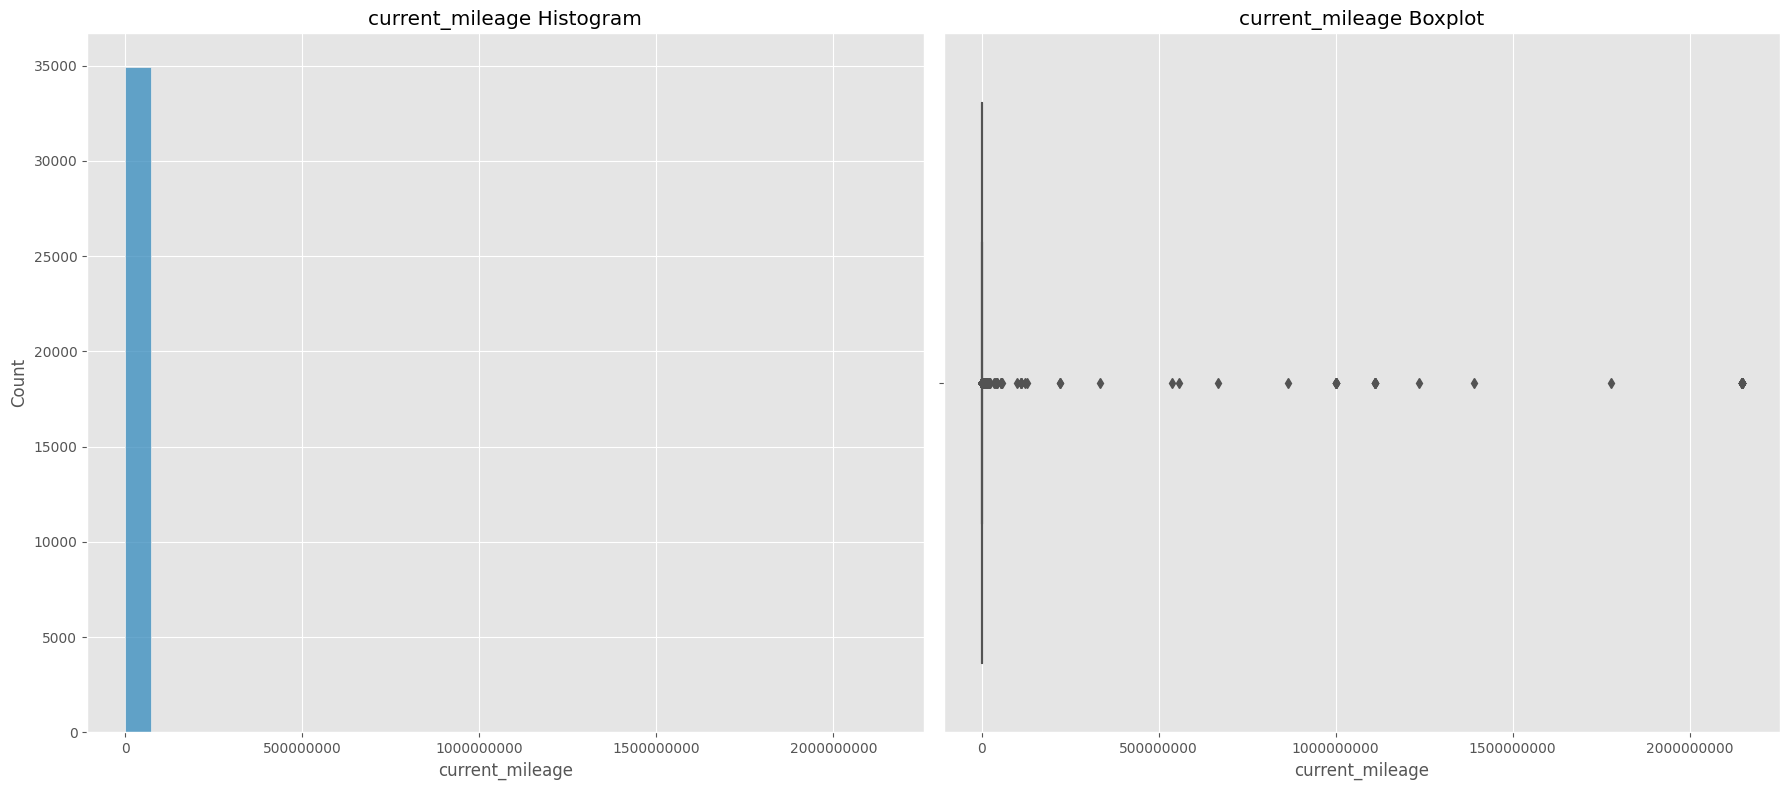

In [34]:
# Смотрю как выглядят распределения пробега, нужно избавится от выбросов за пределами усов
Hist_and_Box_Plots(train_data, 'current_mileage')

In [35]:
# Итеративно вручную на глаз подбираю правый коэффициент, пока не пропадают точки справа от усов
iqr_info_train_data, iqr_outliers_train_data, iqr_clean_train_data = outliers_iqr(train_data, 'current_mileage', log_scale=False, left=1.5, right=1.3)
iqr_info_train_data

'Выбросы: 1453 строк (4.15%).'

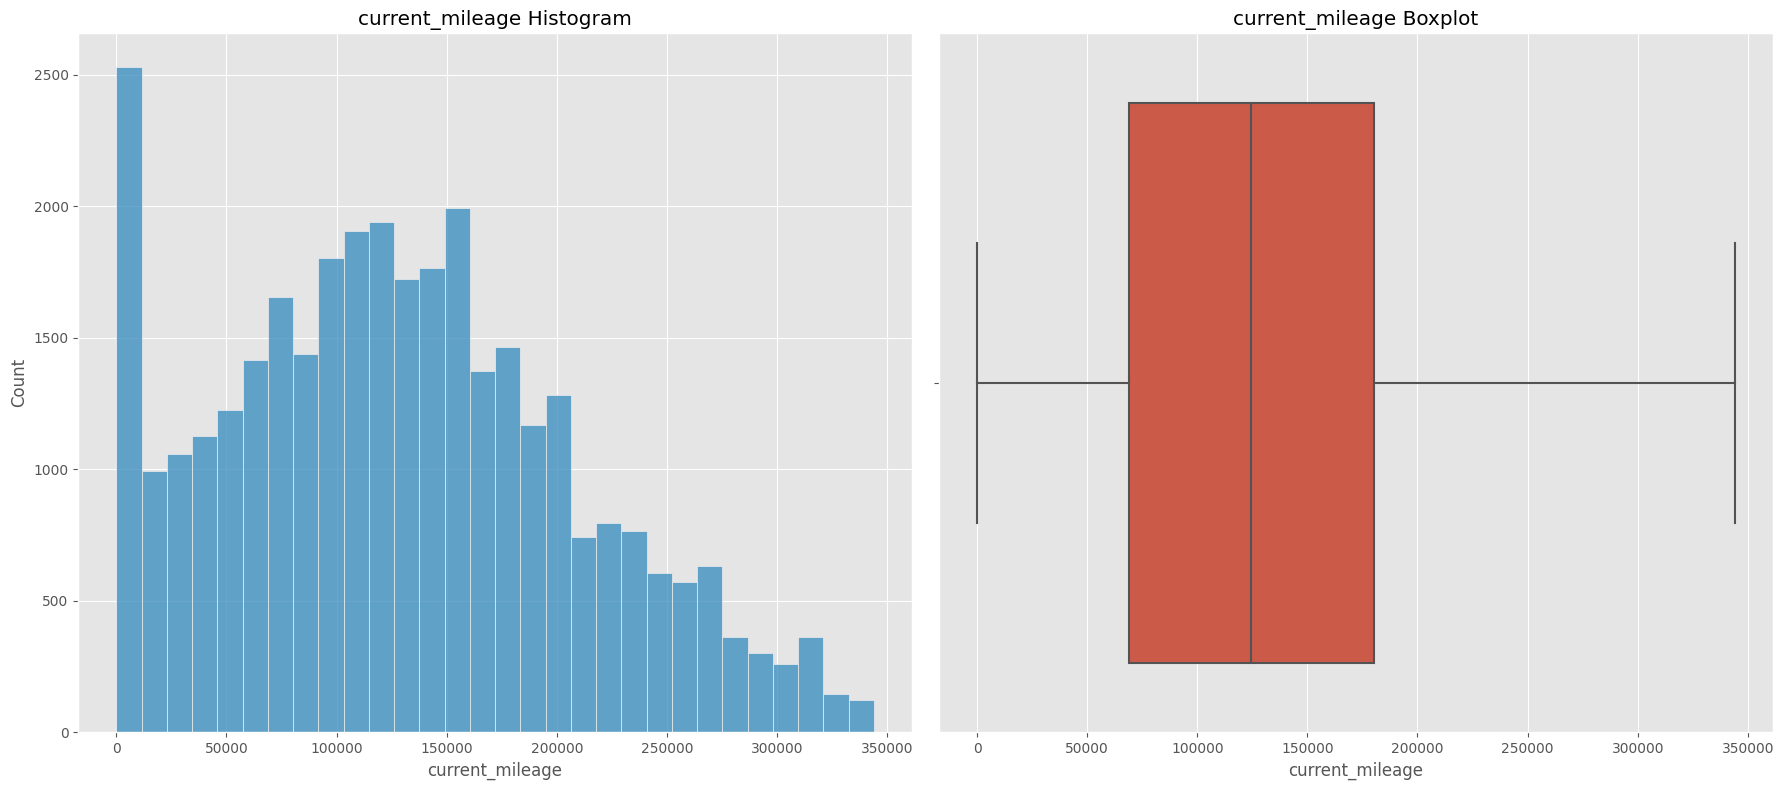

In [36]:
# Смотрю как выглядят распределения пробега после фильтрации
Hist_and_Box_Plots(iqr_clean_train_data, 'current_mileage')

In [37]:
# Сохраняю в список индексы записей которые считаю выбросами
outliers_list = list(iqr_outliers_train_data.index)

In [38]:
# Вспомагательная функция для маркировки признака выбросов по индексу
def mark_by_index(df, ind_list):
    ind = df[0]
    
    if ind in ind_list:
        return True
    
    return False

In [39]:
# Решил не удалять выбросы, а пометить их новым признаком в обоих датасетах
train_data['outliers'] = train_data.apply(mark_by_index, axis=1, args=(outliers_list,))

In [40]:
# Итеративно вручную на глаз подбираю правый коэффициент, пока не пропадают точки справа от усов
iqr_info_test_data, iqr_outliers_test_data, iqr_clean_test_data = outliers_iqr(test_data, 'current_mileage', log_scale=False, left=1.5, right=1.3)
iqr_info_test_data

'Выбросы: 460 строк (4.30%).'

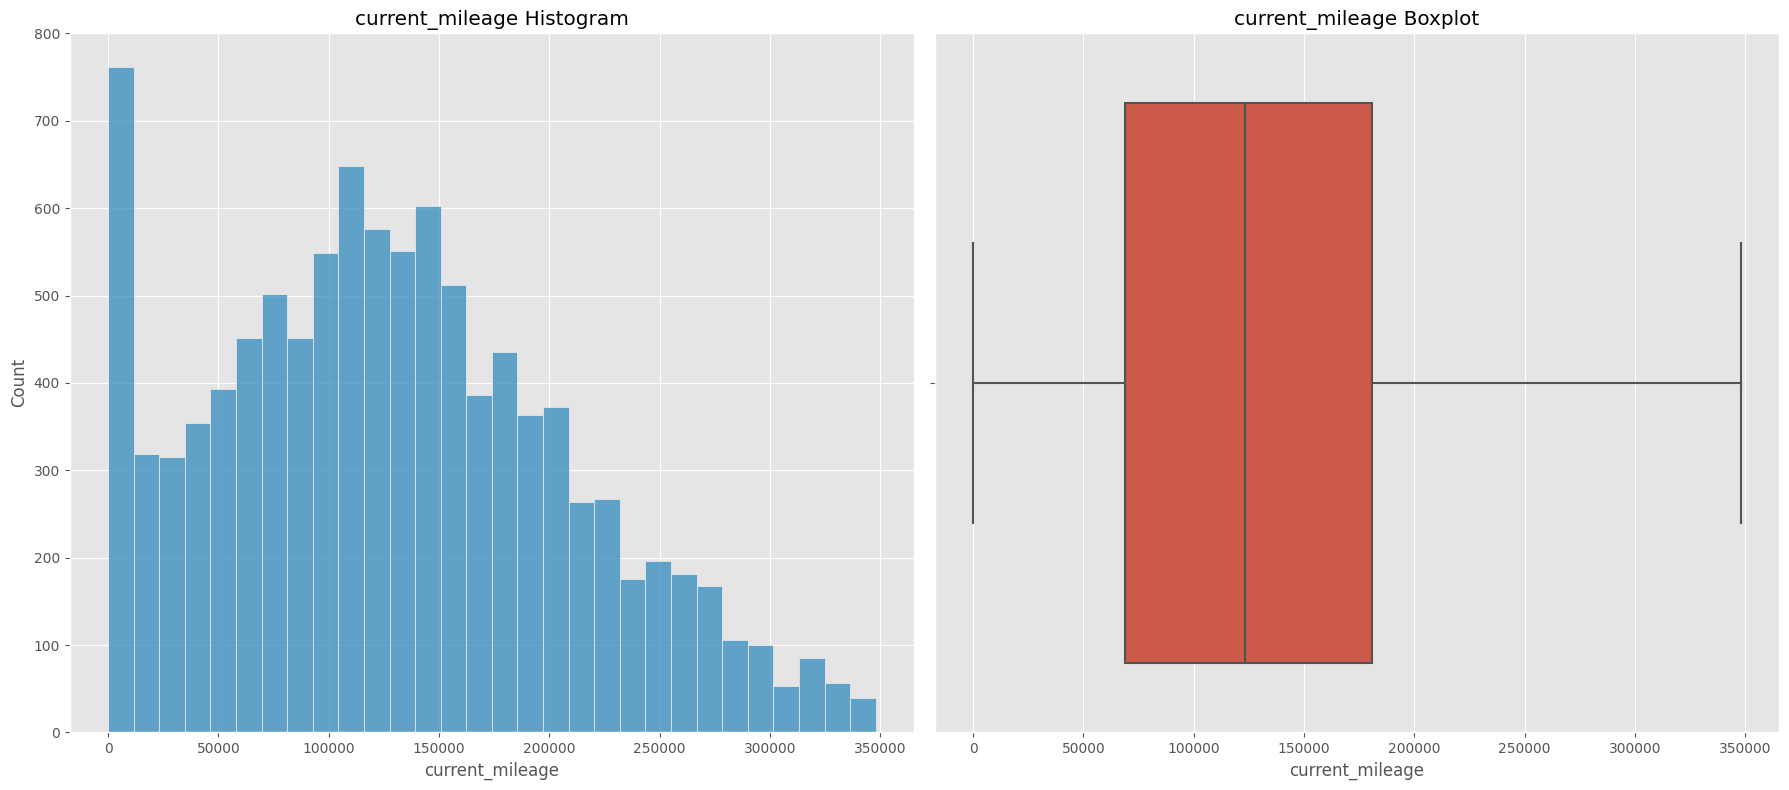

In [41]:
# Смотрю как выглядят распределения пробега после фильтрации по методу Тьки
Hist_and_Box_Plots(iqr_clean_test_data, 'current_mileage')

In [42]:
# Сохраняю в список индексы записей которые считаю выбросами
outliers_list = list(iqr_outliers_test_data.index)

In [43]:
test_data['outliers'] = test_data.apply(mark_by_index, axis=1, args=(outliers_list,))

In [44]:
# Огромные пробеги все же удалаю из тренировочного датасета
train_data = train_data[train_data['current_mileage'] < 500_000]

### Странные значения пробега

In [45]:
# Когда одна и та же цифра от 1 до 9 повторояется более 5 раз
# Это фактически вручную кое-как заполненные пропуски. Просто нажали кнопку с какой-то цифрой несколько раз
re = r'[1]{5,}|[2]{5,}|[3]{5,}|[4]{5,}|[5]{5,}|[6]{5,}|[7]{5,}|[8]{5,}|[9]{5,}'

In [46]:
# С помощью регулярного выражения фильтрую эти данные
train_strange_mileage = train_data[train_data['current_mileage'].astype('str').str.match(re)]
train_strange_mileage

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price,vehicle_age,outliers
402,402,volkswagen,passat,sedan,222222,manual,4/5,left wheel,black,black,None,1,for sale,1700.00,22,False
404,404,ford,transit,microbus,111111,manual,2/3,left wheel,blue,black,None,0,for sale,3700.00,22,False
538,538,honda,fit,sedan,111111,automatic,4/5,left wheel,grey,black,None,0,for sale,2800.00,13,False
609,609,dodge,caravan,minivan,11111,automatic,4/5,left wheel,blue,black,None,0,for sale,1300.00,23,False
610,610,subaru,legacy,sedan,222222,tiptronic,4/5,right-hand drive,black,black,None,0,for sale,1900.00,18,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34041,34041,opel,vectra,sedan,222222,manual,4/5,left wheel,carnelian red,black,None,0,for sale,1500.00,27,False
34447,34447,volkswagen,golf,hatchback,111111,manual,4/5,left wheel,silver,black,None,0,for sale,1900.00,21,False
34690,34690,mercedes-benz,c 300,sedan,111111,tiptronic,4/5,left wheel,black,black,None,1,for sale,6500.00,11,False
34763,34763,ford,transit,goods wagon,11111,manual,4/5,left wheel,white,beige,None,0,for sale,3348.00,24,False


In [47]:
# Также помечаю такие записи True в признаке вылетов
ind_train_list = list(train_strange_mileage.index)
train_data['outliers'] = train_data.apply(mark_by_index, axis=1, args=(ind_train_list,),)

In [48]:
# Тоже самое для тестового датасета
test_strange_mileage = test_data[test_data['current_mileage'].astype('str').str.match(re)]
test_strange_mileage

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,vehicle_age,outliers
34,35034,bmw,530 e60,sedan,111111,tiptronic,4/5,left wheel,silver,black,None,1,for sale,17,False
127,35127,bmw,535,sedan,111111,tiptronic,4/5,left wheel,black,black,None,1,for sale,13,False
352,35352,ford,escape,jeep,111111,automatic,4/5,left wheel,silver,grey,None,0,for sale,13,False
525,35525,bmw,525,sedan,7777787,manual,4/5,left wheel,silver,grey,None,1,for sale,18,False
703,35703,lexus,rx 350,sedan,99999,automatic,4/5,left wheel,black,black,None,1,for rent,10,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10023,45023,honda,fit,sedan,111111,automatic,4/5,right-hand drive,grey,black,None,0,for sale,17,False
10264,45264,vaz,2107,sedan,77777,manual,4/5,left wheel,white,beige,None,0,for sale,24,False
10537,45537,jeep,grand cherokee,jeep,111111,tiptronic,4/5,left wheel,brown,white,None,0,for sale,16,False
10548,45548,bmw,328,sedan,111111,manual,4/5,left wheel,green,black,None,1,for sale,21,False


In [49]:
# Также помечаю такие записи True в признаке вылетов
ind_test_list = list(test_strange_mileage.index)
test_data['outliers'] = test_data.apply(mark_by_index, axis=1, args=(ind_test_list,),)

# Анализ целевого признака

In [50]:
# Нулевая цена и цена в 8млн....
train_data['final_price'].describe()

count     34580.00
mean       5856.24
std       64588.99
min           0.00
25%        1350.00
50%        3900.00
75%        7000.00
max     8388607.00
Name: final_price, dtype: float64

In [51]:
# Всего 4 записи с ценой выше 200т
train_data[train_data['final_price'] > 200_000]

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price,vehicle_age,outliers
3877,3877,volkswagen,golf,sedan,7676,tiptronic,4/5,left wheel,red,golden,None,0,for sale,8388607.00,14,False
12136,12136,bmw,328,sedan,246000,automatic,4/5,left wheel,sky blue,yellow,None,1,for sale,1111111.00,13,False
24980,24980,subaru,legacy,sedan,97000,manual,4/5,right-hand drive,silver,black,None,1,for sale,1111111.00,18,False
32442,32442,opel,combo,goods wagon,99999,manual,2/3,left wheel,blue,black,None,0,for sale,8388607.00,22,True


In [52]:
# B 75 записей автохлама, либо просто мусорных значений
train_data[train_data['final_price'] <= 10]

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price,vehicle_age,outliers
603,603,nissan,note,hatchback,117000,automatic,4/5,right-hand drive,red,black,None,1,for sale,10.00,16,False
883,883,honda,fit,hatchback,0,automatic,4/5,right-hand drive,silver,grey,None,0,for rent,10.00,16,False
1100,1100,toyota,prius,sedan,320000,automatic,4/5,left wheel,white,yellow,None,0,for rent,10.00,13,False
1238,1238,toyota,prius,sedan,45888,automatic,4/5,left wheel,white,black,None,1,for rent,10.00,13,False
1283,1283,toyota,prius,hatchback,111111,automatic,4/5,left wheel,white,black,None,1,for sale,6.00,13,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34255,34255,honda,fit,hatchback,0,automatic,4/5,right-hand drive,grey,beige,None,0,for rent,10.00,16,False
34379,34379,honda,fit,hatchback,0,automatic,4/5,right-hand drive,silver,grey,None,0,for rent,10.00,19,False
34433,34433,toyota,prius,sedan,3200,automatic,4/5,left wheel,white,golden,None,0,for rent,10.00,14,False
34780,34780,toyota,prius c,hatchback,104000,automatic,4/5,left wheel,grey,black,None,1,for sale,2.00,6,False


In [53]:
# Убираю все это из тренировочной выборки
train_data = train_data[(train_data['final_price'] > 10) & (train_data['final_price'] <= 200_000)]

### Дубликаты

In [54]:
# Колонки для поиска дубликатов
cols = list(test_data.columns)[1:]
cols.remove('outliers')
cols.remove('deal_type')
cols

['vehicle_manufacturer',
 'vehicle_model',
 'vehicle_category',
 'current_mileage',
 'vehicle_gearbox_type',
 'doors_cnt',
 'wheels',
 'vehicle_color',
 'vehicle_interior_color',
 'car_vin',
 'car_leather_interior',
 'vehicle_age']

In [55]:
# Создаю сигнальный признак о том что запись дубликат
train_data['duplicate'] = train_data.duplicated(subset=cols)
test_data['duplicate'] = test_data.duplicated(subset=cols)

### Перевожу целевой признак к целому типу, точность излишняя, а модели будет проще работать

In [56]:
train_data[TARGET_NAME] = train_data[TARGET_NAME].astype('int')

### Добавляю признаки модельного года и страны изготовителя, полученные путем парсинга VIN

In [57]:
import vin_parser as vp

In [58]:
def get_country(vin: str):
    if vin == 'no' or len(vin) != 17:
        return 'no'
    country = vp.country(vin)
    return 'no' if country is None else country


def get_model_year(vin: str) -> int:
    if vin == 'no' or len(vin) != 17:
        return 0
    year = vp.year(vin)
    return 0 if year is None else year

In [59]:
train_data.car_vin.fillna('no', inplace=True)
train_data['model_year'] = train_data.car_vin.apply(get_model_year)
train_data['manuf_country'] = train_data.car_vin.apply(get_country)
# train_data.drop(columns=['car_vin'], inplace=True)
test_data.car_vin.fillna('no', inplace=True)
test_data['model_year'] = test_data.car_vin.apply(get_model_year)
test_data['manuf_country'] = test_data.car_vin.apply(get_country)
# test_data.drop(columns=['car_vin'], inplace=True)

### Перед обучением и тестированием проверяю данные на пропуски

In [60]:
train_data.isna().sum().sort_values(ascending=False)

vehicle_interior_color    6677
doors_cnt                  744
vehicle_color              399
vehicle_model                5
car_leather_interior         0
model_year                   0
duplicate                    0
outliers                     0
vehicle_age                  0
final_price                  0
deal_type                    0
row_ID                       0
car_vin                      0
vehicle_manufacturer         0
wheels                       0
vehicle_gearbox_type         0
current_mileage              0
vehicle_category             0
manuf_country                0
dtype: int64

In [61]:
test_data.isna().sum().sort_values(ascending=False)

vehicle_interior_color    2078
doors_cnt                  223
vehicle_color              134
vehicle_model                2
vehicle_category             1
vehicle_gearbox_type         1
wheels                       1
vehicle_manufacturer         1
vehicle_age                  0
model_year                   0
duplicate                    0
outliers                     0
row_ID                       0
deal_type                    0
car_leather_interior         0
car_vin                      0
current_mileage              0
manuf_country                0
dtype: int64

### Удаляю строки с пропусками в производителе и модели в тренировочном и тестовом датасетах

In [62]:
train_data.dropna(subset=['vehicle_manufacturer', 'vehicle_model'], inplace=True)
test_data.dropna(subset=['vehicle_manufacturer', 'vehicle_model'], inplace=True)

In [63]:
display(train_data.isna().sum().sort_values(ascending=False))
test_data.isna().sum().sort_values(ascending=False)

vehicle_interior_color    6677
doors_cnt                  744
vehicle_color              399
car_leather_interior         0
model_year                   0
duplicate                    0
outliers                     0
vehicle_age                  0
final_price                  0
deal_type                    0
row_ID                       0
car_vin                      0
vehicle_manufacturer         0
wheels                       0
vehicle_gearbox_type         0
current_mileage              0
vehicle_category             0
vehicle_model                0
manuf_country                0
dtype: int64

vehicle_interior_color    2077
doors_cnt                  222
vehicle_color              133
car_vin                      0
model_year                   0
duplicate                    0
outliers                     0
vehicle_age                  0
deal_type                    0
car_leather_interior         0
row_ID                       0
vehicle_manufacturer         0
wheels                       0
vehicle_gearbox_type         0
current_mileage              0
vehicle_category             0
vehicle_model                0
manuf_country                0
dtype: int64

### Создаю функцию, заменяющую пропуски модой

In [64]:
def fillna_by_mode(df, column):
    global_mode = df[column].value_counts()[0]
    
    missing_manufs_models = df[df[column].isna()].groupby(['vehicle_manufacturer', 'vehicle_model'])['row_ID'].count().index

    modes_dict = {}
    for manuf, model in missing_manufs_models:
        manuf_model = f'{manuf}_{model}'
        df_slice = df[(df.vehicle_manufacturer==manuf) & (df.vehicle_model==model)][[column]]
        if  df_slice.isna().sum()[0] == df_slice.shape[0]:
            mode = global_mode
        else:
            mode = df_slice.value_counts().index[0]
        modes_dict[manuf_model] = mode
    
    missing_idx = df[df[column].isna()].index
    df.loc[missing_idx, column] = df.loc[missing_idx][['vehicle_manufacturer', 'vehicle_model']].apply(
        lambda x: modes_dict[f'{x["vehicle_manufacturer"]}_{x["vehicle_model"]}'],
        axis=1
    )

### Заменяю пропуски модой для vehicle_interior_color, doors_cnt и vehicle_color. Моду берем в выборке с соответствующими производителем и моделью

In [65]:
fillna_by_mode(train_data, 'vehicle_interior_color')
fillna_by_mode(train_data, 'doors_cnt')
fillna_by_mode(train_data, 'vehicle_color')

fillna_by_mode(test_data, 'vehicle_interior_color')
fillna_by_mode(test_data, 'doors_cnt')
fillna_by_mode(test_data, 'vehicle_color')

### Извлекаю данные о стране изготовителе и модельном годе из VIN

In [66]:
# import vin_parser as vp



# def get_country(vin: str):
#     if vin == 'no' or len(vin) != 17:
#         return 'no'
#     country = vp.country(vin)
#     return 'no' if country is None else country


# train_data['manuf_country'] = train_data.car_vin.apply(get_country)
# test_data['manuf_country'] = test_data.car_vin.apply(get_country)


# def get_model_year(vin: str) -> int:
#     if vin == 'no' or len(vin) != 17:
#         return 0
#     year = vp.year(vin)
#     return 0 if year is None else year


# train_data['model_year'] = train_data.car_vin.apply(get_model_year)
# test_data['model_year'] = test_data.car_vin.apply(get_model_year)


### Перевожу все строковые данные в категориальный тип

In [67]:
# train_data = pd.concat([
#     train_data.select_dtypes([], ['object']),
#     train_data.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')],
#     axis=1)
# train_data.info()

In [68]:
# test_data = pd.concat([
#     test_data.select_dtypes([], ['object']),
#     test_data.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')],
#     axis=1)
# test_data.info()

### Финальная проверка на пропуски перед обучением модели

In [69]:
train_data.isna().sum().sum()

0

In [70]:
test_data.isna().sum().sum()

0

### 0.6. Data splitting for train-holdout
As we have only one file with target values, we can split it into 80%-20% for holdout usage:

In [71]:
tr_data, te_data = train_test_split(
    train_data, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data splitted. Parts sizes: tr_data = (27494, 19), te_data = (6874, 19)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price,vehicle_age,outliers,duplicate,model_year,manuf_country
27506,27506,hyundai,sonata,sedan,58563,automatic,4/5,left wheel,white,black,no,1,for sale,13988,5,False,False,0,no
19168,19168,hyundai,sonata,sedan,51274,automatic,4/5,left wheel,silver,black,no,1,for sale,4900,6,False,True,0,no
29469,29469,hyundai,tucson,jeep,152872,automatic,4/5,left wheel,silver,black,no,1,for sale,6784,10,False,False,0,no
33333,33333,dodge,ramcharger,sedan,173770,automatic,4/5,left wheel,white,black,no,1,for sale,1400,7,False,True,0,no
6828,6828,chevrolet,volt,hatchback,150517,automatic,4/5,left wheel,black,black,1g1rh6e41du101781,1,for sale,1450,8,False,False,2013,United States


# 1. Task definition

### 1.1. Task type

On the cell below we create Task object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation):

In [72]:
task = Task('reg', loss = 'mae', metric = 'mae')

### 1.2. Feature roles setup

To solve the task, we need to setup columns roles. The **only role you must setup is target role**, everything else (drop, numeric, categorical, group, weights etc.) is up to user - LightAutoML models have automatic columns typization inside:

In [73]:
roles = {
    'target': TARGET_NAME,
    'drop': ['row_ID', 'deal_type'] # признак deal_type не использую для построения модели
}

### 1.3. LightAutoML model creation - TabularAutoML preset

In next the cell we are going to create LightAutoML model with `TabularAutoML` class - preset with default model structure like in the image below:

<img src="https://github.com/AILab-MLTools/LightAutoML/raw/master/imgs/tutorial_blackbox_pipeline.png" alt="TabularAutoML preset pipeline" style="width:85%;"/>

in just several lines. Let's discuss the params we can setup:
- `task` - the type of the ML task (the only **must have** parameter)
- `timeout` - time limit in seconds for model to train
- `cpu_limit` - vCPU count for model to use
- `reader_params` - parameter change for Reader object inside preset, which works on the first step of data preparation: automatic feature typization, preliminary almost-constant features, correct CV setup etc. For example, we setup `n_jobs` threads for typization algo, `cv` folds and `random_state` as inside CV seed.

**Important note**: `reader_params` key is one of the YAML config keys, which is used inside `TabularAutoML` preset. [More details](https://github.com/AILab-MLTools/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) on its structure with explanation comments can be found on the link attached. Each key from this config can be modified with user settings during preset object initialization. To get more info about different parameters setting (for example, ML algos which can be used in `general_params->use_algos`) please take a look at our [article on TowardsDataScience](https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936).

Moreover, to receive the automatic report for our model we can use `ReportDeco` decorator and work with the decorated version in the same way as we do with usual one (more details in [this tutorial](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials/Tutorial_1_basics.ipynb))

In [74]:
# В статье увидел у разработчиков, что это класс работает лучше чем TabularAutoML
automl = TabularUtilizedAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

# 2. AutoML training

To run autoML training use fit_predict method:
- `train_data` - Dataset to train.
- `roles` - Roles dict.
- `verbose` - Controls the verbosity: the higher, the more messages.
        <1  : messages are not displayed;
        >=1 : the computation process for layers is displayed;
        >=2 : the information about folds processing is also displayed;
        >=3 : the hyperparameters optimization process is also displayed;
        >=4 : the training process for every algorithm is displayed;

Note: out-of-fold prediction is calculated during training and returned from the fit_predict method

In [75]:
%%time
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)

[11:12:10] Start automl utilizator with listed constraints:
[11:12:10] - time: 1800.00 seconds
[11:12:10] - CPU: 12 cores
[11:12:10] - memory: 16 GB

[11:12:10] If one preset completes earlier, next preset configuration will be started

[11:12:10] ==================================================
[11:12:10] Start 0 automl preset configuration:
[11:12:10] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[11:12:10] Stdout logging level is INFO.
[11:12:10] Task: reg

[11:12:10] Start automl preset with listed constraints:
[11:12:10] - time: 1800.00 seconds
[11:12:10] - CPU: 12 cores
[11:12:10] - memory: 16 GB

[11:12:10] Train data shape: (27494, 19)



TypeError: 'values' is not ordered, please explicitly specify the categories order by passing in a categories argument.

In [ ]:
print(automl.create_model_str_desc())

# 3. Prediction on holdout and model evaluation

We now have the trained model called `automl` and it's time to see what MAE score it can receive on train and holdout data:

In [ ]:
%%time
te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

In [ ]:
# print(f'TRAIN out-of-fold score: {mean_absolute_error(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {mean_absolute_error(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')

# 4. Feature importances calculation 

For feature importances calculation we have 2 different methods in LightAutoML:
- Fast (`fast`) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). no need to use new labelled data.
- Accurate (`accurate`) - this method calculate *features permutation importances* for the whole LightAutoML model based on the **new labelled data**. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).

In [ ]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [ ]:
# %%time
# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate on bigger datasets
# accurate_fi = automl.get_feature_scores('accurate', te_data, silent = False)

In [ ]:
# accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

# 5. Predict for test dataset

We are also ready to predict for our test competition dataset and submission file creation:

### Для более качественной модели использую весь датасет train_data

In [ ]:
automl = TabularUtilizedAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

In [ ]:
%%time
oof_pred = automl.fit_predict(train_data, roles = roles, verbose = 1)

In [ ]:
train_data.isna().sum()

In [ ]:
print(f'FULL TRAIN score: {mean_absolute_error(train_data[TARGET_NAME].values, oof_pred.data[:, 0])}')

In [ ]:
test_pred = automl.predict(test_data)
print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')

In [ ]:
submission[TARGET_NAME] = test_pred.data[:, 0]
submission

In [ ]:
# Арендные авто обрабатываю вручную, меняю все значения на мединанную стоимость аренды в 16 долл
submission.at[rent_cars_index_list, 'final_price'] = 16

In [ ]:
# Ручная правка полностью нулевой записи
submission.at[index_to_set_zero, 'final_price'] = 0

In [ ]:
submission.to_csv('final.csv', index = False)

# Additional materials

- [Official LightAutoML github repo](https://github.com/AILab-MLTools/LightAutoML)
- [LightAutoML documentation](https://lightautoml.readthedocs.io/en/latest)
- [LightAutoML tutorials](https://github.com/AILab-MLTools/LightAutoML/tree/master/examples/tutorials)
- LightAutoML course:
    - [Part 1 - general overview](https://ods.ai/tracks/automl-course-part1) 
    - [Part 2 - LightAutoML specific applications](https://ods.ai/tracks/automl-course-part2)
    - [Part 3 - LightAutoML customization](https://ods.ai/tracks/automl-course-part3)
- [OpenDataScience AutoML benchmark leaderboard](https://ods.ai/competitions/automl-benchmark/leaderboard)

### If you still like the notebook, do not forget to put upvote for the notebook and the ⭐️ for github repo if you like it using the button below - one click for you, great pleasure for us ☺️

### If you miss the [simple baseline notebook](https://www.kaggle.com/code/alexryzhkov/clone-my-notebook) for this competition, please take a look and upvote it as well. 